<a href="https://colab.research.google.com/github/yunama47/CapstoneTeamC23-PC621/blob/main/Model/image_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [2]:
import os
import shutil
import random
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization, Flatten, Input
tf.__version__

'2.12.0'

In [3]:
SPLIT_SIZE = 0.8
BATCH_SIZE = 18
IMAGE_SIZE = (224, 224)
CLASSES = ['not_eligible','eligible']
BASE_DIR = '/content/Houses-Images'

# Functions

In [4]:
def create_dir(dir):
  dir = os.path.join(BASE_DIR,dir)
  os.mkdir(dir) if not os.path.isdir(dir) else print(f'{dir} already created')
  return dir

def train_test_split(imdir,split_size):

  def copy_files(files,copy_dir):
    label = imdir.split('/')[-1]
    for file in files:
      src = os.path.join(imdir,file)
      dst = os.path.join(copy_dir,label,file)
      shutil.copyfile(src,dst)

  img_files = os.listdir(imdir)
  random.shuffle(img_files)
  split = int(split_size * len(img_files))
  train_files = img_files[:split]
  test_files = img_files[split:]
  copy_files(train_files,train_dir)
  copy_files(test_files,test_dir)

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'last accucary result : acc = {acc[-1]}, val_acc = {val_acc[-1]}')
  print(f'last loss result : loss = {loss[-1]}, val_loss = {val_loss[-1]}')

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# images dataset

Download zip file from drive

In [5]:
url = 'https://drive.google.com/uc?id=1g6EQGwMZvstP7Q5uioca4Yk30n6DlfgU&export=download&confirm=t'
local_zip = "/content/house_image.zip"
tf.keras.utils.get_file(fname=local_zip, origin=url)

314898372/314898372 [==============================] - 2s 0us/step


'/content/house_image.zip'

extract images

In [6]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [7]:
uneligible_house_dir = os.path.join(BASE_DIR,'not_eligible')
eligible_house_dir = os.path.join(BASE_DIR,'eligible')

print(f'there is {len(os.listdir(uneligible_house_dir))} files in {uneligible_house_dir}')
print(f'there is {len(os.listdir(eligible_house_dir))} files in {eligible_house_dir}')

there is 90 files in /content/Houses-Images/not_eligible
there is 90 files in /content/Houses-Images/eligible


In [8]:
# create directory for train and test
train_dir = create_dir('train')
test_dir = create_dir('test')
_ = create_dir('train/eligible')
_ = create_dir('train/not_eligible')
_ = create_dir('test/eligible')
_ = create_dir('test/not_eligible')

train test splitting

In [9]:
train_test_split(eligible_house_dir,SPLIT_SIZE)
train_test_split(uneligible_house_dir,SPLIT_SIZE)

In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=IMAGE_SIZE, 
        batch_size=BATCH_SIZE,
        classes=CLASSES,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        classes=CLASSES,
        class_mode='binary')

Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


### visualize some images

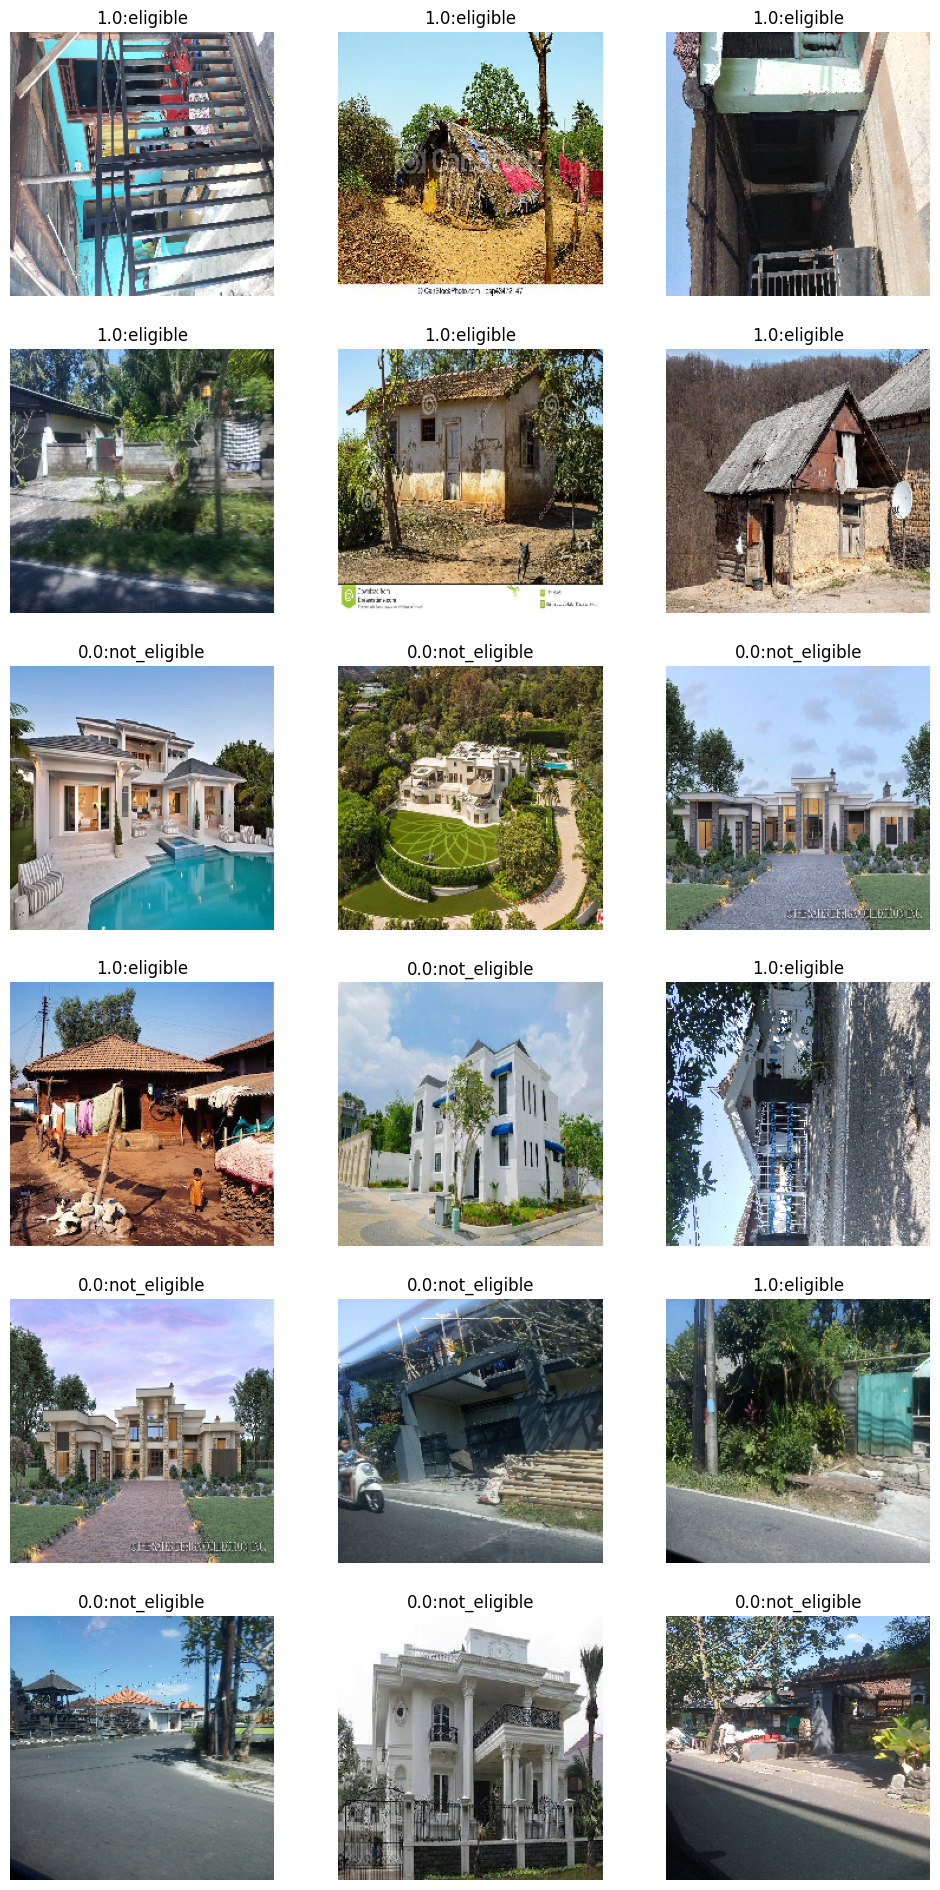

In [11]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 3
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

images, labels = validation_generator[0]
for i, img in enumerate(images):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  l = labels[i]
  plt.title(f'{l}:{CLASSES[int(l)]}')
  plt.imshow(img)

plt.show()


create model

# Model Development

Transfer learning using MobileNet

In [12]:
image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling='max',
)
# Set base_model to be trainable
base_model.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(),
          activity_regularizer=regularizers.l1(),
          bias_regularizer=regularizers.l1())(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

17225924/17225924 [==============================] - 0s 0us/step


Epoch 1/30
8/8 - 40s - loss: 1.9711 - accuracy: 0.5764 - val_loss: 2.8798 - val_accuracy: 0.6944 - lr: 0.0010 - 40s/epoch - 5s/step
Epoch 2/30
8/8 - 31s - loss: 1.7977 - accuracy: 0.6181 - val_loss: 2.6980 - val_accuracy: 0.5278 - lr: 0.0010 - 31s/epoch - 4s/step
Epoch 3/30
8/8 - 28s - loss: 1.5551 - accuracy: 0.7292 - val_loss: 2.8040 - val_accuracy: 0.5000 - lr: 0.0010 - 28s/epoch - 4s/step
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
8/8 - 29s - loss: 1.5222 - accuracy: 0.7292 - val_loss: 3.3918 - val_accuracy: 0.5000 - lr: 0.0010 - 29s/epoch - 4s/step
Epoch 5/30
8/8 - 31s - loss: 1.5060 - accuracy: 0.7500 - val_loss: 2.9951 - val_accuracy: 0.5000 - lr: 1.0000e-04 - 31s/epoch - 4s/step
Epoch 6/30
8/8 - 29s - loss: 1.4667 - accuracy: 0.7778 - val_loss: 2.5703 - val_accuracy: 0.5000 - lr: 1.0000e-04 - 29s/epoch - 4s/step
Epoch 7/30
8/8 - 30s - loss: 1.3899 - accuracy: 0.8333 - val_loss: 2.2780 - val_accuracy: 0.5278 - lr: 1.0000e-04 - 30s/ep

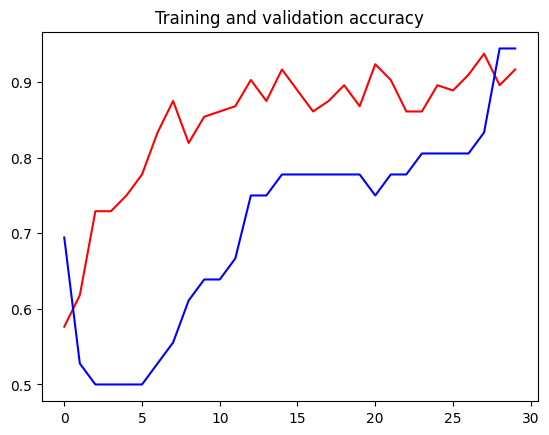

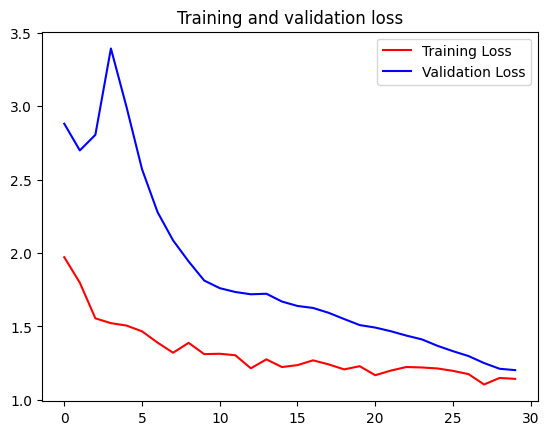

In [13]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2,verbose=1)
history = model.fit(train_generator,
                    epochs=30,
                    callbacks=[rlronp],
                    validation_data=validation_generator,
                    verbose=2)
plot_loss_acc(history)

In [14]:
model.save('image_model.h5')